In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os, glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from transformers import Dinov2Model



/Users/k.choi/opt/miniconda3/envs/pytorch_csiro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
project_dir = '/Users/k.choi/Documents/github/csiro_git'
data_dir  = os.path.join(project_dir, 'data')
model_dir = os.path.join(project_dir, 'models')

train_csv = pd.read_csv(os.path.join(data_dir, 'train.csv'))
device    = torch.device('mps')

In [6]:
unique_paths  = train_csv['image_path'].unique(); print(unique_paths.shape)

(357,)


In [7]:
train_csv['target_name'].unique()

array(['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g',
       'GDM_g'], dtype=object)

In [8]:
def data_preprocess(df, data_dir):
    data_list = []
    
    unique_paths = df['image_path'].unique()
    target_names = df['target_name'].unique()

    for paths in unique_paths:
        data = df[ df['image_path'] == paths ]
        row = { 'image_path': paths }
        for tar in target_names:
            row[tar] = data[ data['target_name'] == tar ]['target'].values[0]
        
        data_list.append(row)

    return pd.DataFrame(data_list)

data_df = data_preprocess(train_csv, data_dir); display(data_df)


,image_path,Dry_Clover_g,Dry_Dead_g,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,0.0000,31.9984,16.2751,48.2735,16.2750
1,train/ID1012260530.jpg,0.0000,0.0000,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,0.0000,30.9703,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,0.4343,23.2239,10.5261,34.1844,10.9605
...,...,...,...,...,...,...
352,train/ID975115267.jpg,40.0300,0.0000,0.8000,40.8300,40.8300
353,train/ID978026131.jpg,24.6445,4.1948,12.0601,40.8994,36.7046
354,train/ID980538882.jpg,0.0000,1.1457,91.6543,92.8000,91.6543
355,train/ID980878870.jpg,32.3575,0.0000,2.0325,34.3900,34.3900


In [22]:
train_data, test_data  = train_test_split(data_df, test_size=0.01, random_state=8964); print(f'train: {len(train_data)}, test: {len(test_data)}')

train: 353, test: 4


In [23]:
def create_stratified_folds(df, target_col='Dry_Total_g', n_folds=5, random_state=8964):
    strata_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)
 
    bins = [0, 20, 40, 60, 80, np.inf]
    dfcopy = df.copy()
    dfcopy['strata'] = pd.cut(dfcopy[target_col], bins=bins, labels=False) 
    
    kfolds = []
    for train_idx, val_idx in strata_kfold.split(dfcopy, dfcopy['strata']):
        kfolds.append((train_idx, val_idx))
    
    return kfolds

kfolds  = create_stratified_folds(train_data, target_col='Dry_Total_g', n_folds=5)

for i, (train_idx, val_idx) in enumerate(kfolds): 
    print(f"Fold {i+1}: {len(train_idx)} train, {len(val_idx)} val")
    assert len(train_idx) + len(val_idx) == len(train_data)

Fold 1: 282 train, 71 val
Fold 2: 282 train, 71 val
Fold 3: 282 train, 71 val
Fold 4: 283 train, 70 val
Fold 5: 283 train, 70 val


In [24]:
class tta:

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std 

    def get_transforms(self):
        return [
            ( 'id',     self.__get_id()),
            ( 'hflip',  self.__get_hflip()),
            ( 'vflip',  self.__get_vflip()),
            ( 'rot90',  self.__get_rota(90)),
            ( 'rot180', self.__get_rota(180)),
            ( 'rot270', self.__get_rota(270)) ]

    def __get_id(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])

    def __get_hflip(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(p=1),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])

    def __get_vflip(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomVerticalFlip(p=1),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])
        
    def __get_rota(self,angle):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Lambda(lambda img: transforms.functional.rotate(img, angle)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std) ])
         

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]  

tta_transforms = tta(mean=mean, std=std)
tta_list = tta_transforms.get_transforms()

for names, _ in tta_list: print(names)

id
hflip
vflip
rot90
rot180
rot270


In [25]:
class random_tranfo:

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def get_transfo(self):
        return [ self.train_transform(), self.valid_transform() ]
        
    ### no rota because no differences
    def train_transform(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])
    
    def valid_transform(self):
        return transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
        ])
     

rand_transfo = random_tranfo(mean=mean, std=std)
train_transfo, valid_transfo = rand_transfo.get_transfo()


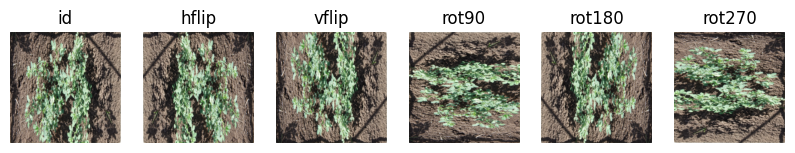

In [26]:
img_path = os.path.join( data_dir, np.random.choice(unique_paths)) 

fig,axes = plt.subplots(1,6, figsize=(10,3))
for i, (name, transform) in enumerate(tta_list):
    img = Image.open(img_path)
    img = transform(img)
    
    mean = torch.tensor( [0.485, 0.456, 0.406] ).view(3,1,1)
    std  = torch.tensor( [0.229, 0.224, 0.225] ).view(3,1,1)

    img  = img * std + mean
    img  = torch.clamp(img,0,1)
    img  = img.permute(1,2,0).numpy()

    axes[i].imshow(img)
    axes[i].set_title(name)
    axes[i].axis('off')

plt.show()

In [35]:
class BiomassDS(Dataset):
    def __init__(self, df, data_dir, transform, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        self.target_names = target_names

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = os.path.join(self.data_dir, row['image_path'])
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        targets = torch.tensor([row[col] for col in self.target_names], dtype=torch.float32)
        return img, targets

In [36]:
# class TTABiomassDS(Dataset):
#     def __init__(self, df, data_dir, transform, target_names = ['Dry_Clover_g','Dry_Dead_g', 'Dry_Green_g','Dry_Total_g','GDM_g']):
#         self.df = df.reset_index(drop=True)
#         self.data_dir = data_dir
#         self.transform = transform
#         self.target_names = target_names

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         row = self.df.iloc[idx]
#         img = Image.open(os.path.join(self.data_dir, row['image_path'])).convert('RGB')


In [37]:
class call_my_dino(nn.Module):
    def __init__(self, backbone, patch_dim, n_targets):
        super().__init__()
        
        self.backbone = backbone
        for params in self.backbone.parameters():
            params.requires_grad = False

        self.dino_head = nn.Sequential(
            nn.Linear(patch_dim, 512),
            nn.LayerNorm(512),  
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LayerNorm(256),  
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(256, n_targets),
        )

    def forward(self, x):
        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :]

        batch_size, n_patches, patch_dim = patch_features.shape
        patch_features_flat = patch_features.reshape(-1, patch_dim)
        patch_pred = self.dino_head(patch_features_flat)
        patch_pred = patch_pred.reshape(batch_size, n_patches, -1)

        final_pred = torch.mean(patch_pred, dim=1)

        return final_pred, patch_pred

In [38]:
small_dinov2_backbone = Dinov2Model.from_pretrained('facebook/dinov2-small');
small_dinov2_backbone.eval();
small_dinov2_backbone.to(device);

In [39]:
# dino_model = call_my_dino(small_dinov2_backbone, patch_dim=384, n_targets=5)

# dino_model.load_state_dict(torch.load(os.path.join(model_dir, 'dino_model_small.pth')))
# dino_model.to(device)
# dino_model.eval()

In [44]:
from sklearn.metrics import mean_squared_error

def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss , batch = 0 , 0 

    pbar = tqdm(train_loader, desc='Training')
    for img, tar in pbar:
        img, tar = img.to(device), tar.to(device)

        optimizer.zero_grad()
        pred, _ = model(img)
        loss = criterion(pred, tar)

        loss.backward(); optimizer.step()
        total_loss += loss.item(); batch += 1 
    return total_loss / batch

def valid_epoch(model, valid_loader, criterion, device):
    model.eval()
    total_loss , batch = 0 , 0 

    all_pred, all_tar = [], []
    with torch.no_grad():

        pbar = tqdm(valid_loader, desc='Validation')
        for img, tar in pbar:
            img, tar = img.to(device), tar.to(device)
            
            pred, _ = model(img)
            loss    = criterion(pred, tar)

            total_loss += loss.item(); batch += 1

            all_pred.append(pred.cpu()); all_tar.append(tar.cpu())

    all_pred = torch.cat(all_pred).numpy()
    all_tar  = torch.cat(all_tar).numpy()

    avg_loss = total_loss / batch
    rmse     = np.sqrt(mean_squared_error(all_pred, all_tar))

    return avg_loss, rmse

In [ ]:
MAX_EPOCHS = 20

LR = 1e-3
WEIGHT_DECAY = 1e-4
LR_PATIENCE = 5
PATIENCE = 10

batch_size  = 16

criterion = nn.MSELoss()

fold_model, fold_history, fold_best_rmses = [], [], []


for fold_idx, (train_idx, val_idx) in enumerate(kfolds):

    train_fold = train_data.iloc[train_idx]
    valid_fold = train_data.iloc[val_idx]

    print(f'Fold {fold_idx+1} : {len(train_idx)} train, {len(val_idx)} val')

    train_ds     = BiomassDS(df =train_fold, data_dir =data_dir, transform = train_transfo)
    valid_ds     = BiomassDS(df =valid_fold, data_dir =data_dir, transform = valid_transfo)
    
    train_loader = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    valid_loader = DataLoader(valid_ds, batch_size= batch_size, shuffle=False)
 
    print('Dataloader completed')
    model = call_my_dino(small_dinov2_backbone, patch_dim=384, n_targets=5)
    model.to(device)

    print('Dino has been summoned')
 
    optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY) 
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience= LR_PATIENCE)
 
    print('Optimizer has arrived so as the scheduler')
    print(' ==' * 32)

    history = {'train_loss':[], 'valid_loss':[], 'rmse':[], 'learning_rate':[]}
    best_val, best_rmse, best_epoch, epoch_counter, best_model = np.inf,0,0,0, None

    for epoch in range(MAX_EPOCHS):

        print(f'Epoch {epoch+1} / {MAX_EPOCHS}')
        print(' -' * 32)
        epoch_counter += 1

        train_loss              = train_epoch(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_rmse  = valid_epoch(model, valid_loader, criterion, device)
        
        scheduler.step(valid_loss)
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['valid_loss'].append(valid_loss)
        history['rmse'].append(valid_rmse)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Train loss: {train_loss:.4f}, Valid loss: {valid_loss:.4f}, Valid RMSE: {valid_rmse:.4f}')
        if valid_loss < best_val:
            best_val  = valid_loss
            best_rmse = valid_rmse
            best_epoch = epoch
            best_model = model.state_dict()

            torch.save(best_model, os.path.join(model_dir, f'best_model_fold_{fold_idx}.pth'))
            epoch_counter = 0

            print(f'New best model at epoch {best_epoch} with val_loss {best_val}')
        else:
            print(f'no improvement since epoch {best_epoch} with val_loss {best_val}')
            epoch_counter += 1
        
        if epoch_counter >= PATIENCE:
            print(f'Early stopping at epoch {epoch_counter}, best model at epoch {best_epoch}')
            break

    fold_history.append(history) 
    fold_model.append(best_model) 
    fold_best_rmses.append(best_rmse)

    torch.mps.empty_cache()
    

Fold 1 : 282 train, 71 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Training:   0%|          | 0/18 [00:00<?, ?it/s]

Validation: 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


Train loss: 1156.7425, Valid loss: 896.3326, Valid RMSE: 31.0778
New best model at epoch 0 with val_loss 896.3326293945313
Epoch 2 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 1032.8934, Valid loss: 801.9202, Valid RMSE: 29.4357
New best model at epoch 1 with val_loss 801.9201965332031
Epoch 3 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 927.8267, Valid loss: 714.8081, Valid RMSE: 27.8216
New best model at epoch 2 with val_loss 714.808056640625
Epoch 4 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 878.1961, Valid loss: 641.7461, Valid RMSE: 26.3768
New best model at epoch 3 with val_loss 641.746142578125
Epoch 5 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


Train loss: 766.2156, Valid loss: 578.9376, Valid RMSE: 25.0526
New best model at epoch 4 with val_loss 578.9376281738281
Epoch 6 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Train loss: 679.0444, Valid loss: 529.3551, Valid RMSE: 23.9433
New best model at epoch 5 with val_loss 529.3551361083985
Epoch 7 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 623.3148, Valid loss: 487.2870, Valid RMSE: 22.9774
New best model at epoch 6 with val_loss 487.2870300292969
Epoch 8 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 578.9983, Valid loss: 446.6404, Valid RMSE: 22.0201
New best model at epoch 7 with val_loss 446.64044189453125
Epoch 9 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Train loss: 524.5581, Valid loss: 412.9191, Valid RMSE: 21.1528
New best model at epoch 8 with val_loss 412.9191070556641
Epoch 10 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 477.4867, Valid loss: 383.6702, Valid RMSE: 20.3442
New best model at epoch 9 with val_loss 383.67018737792966
Epoch 11 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 444.0205, Valid loss: 360.3124, Valid RMSE: 19.6690
New best model at epoch 10 with val_loss 360.3124053955078
Epoch 12 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 421.0805, Valid loss: 334.3100, Valid RMSE: 18.9137
New best model at epoch 11 with val_loss 334.3100311279297
Epoch 13 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 391.1304, Valid loss: 316.8399, Valid RMSE: 18.3705
New best model at epoch 12 with val_loss 316.8398712158203
Epoch 14 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 359.7758, Valid loss: 294.2208, Valid RMSE: 17.6432
New best model at epoch 13 with val_loss 294.22084655761716
Epoch 15 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 332.7459, Valid loss: 279.4604, Valid RMSE: 17.2015
New best model at epoch 14 with val_loss 279.46039123535155
Epoch 16 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 307.9767, Valid loss: 266.3413, Valid RMSE: 16.7079
New best model at epoch 15 with val_loss 266.34129638671874
Epoch 17 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 296.1396, Valid loss: 252.9251, Valid RMSE: 16.2656
New best model at epoch 16 with val_loss 252.92514038085938
Epoch 18 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Train loss: 279.6274, Valid loss: 244.4623, Valid RMSE: 15.8936
New best model at epoch 17 with val_loss 244.4623016357422
Epoch 19 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Train loss: 251.3973, Valid loss: 228.5875, Valid RMSE: 15.3466
New best model at epoch 18 with val_loss 228.58746948242188
Epoch 20 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 239.5548, Valid loss: 226.2696, Valid RMSE: 15.2224
New best model at epoch 19 with val_loss 226.2695526123047
Fold 2 : 282 train, 71 val
Dataloader completed
Dino has been summoned
Optimizer has arrived so as the scheduler
 == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ==
Epoch 1 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Train loss: 1084.0662, Valid loss: 1220.3421, Valid RMSE: 35.5835
New best model at epoch 0 with val_loss 1220.34208984375
Epoch 2 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Train loss: 954.8993, Valid loss: 1109.5500, Valid RMSE: 33.9761
New best model at epoch 1 with val_loss 1109.55
Epoch 3 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Validation: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Train loss: 855.7930, Valid loss: 1007.9537, Valid RMSE: 32.4305
New best model at epoch 2 with val_loss 1007.9536743164062
Epoch 4 / 20
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


Training:  78%|███████▊  | 14/18 [00:10<00:03,  1.30it/s]